In [1]:
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

## First, get the images from bing search

In [3]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', '9c48cbf8d396475fb4741f041fd985ef')

In [4]:
# search_images_bing returns a slightly modified fastai list of Azure's ImageObject class, size of list=150
results = search_images_bing(key, 'raven')
# get the url of the images in the list
ims = results.attrgot('contentUrl')
len(ims)

150

### Display one of the images found

In [5]:
dest = 'images/raven.jpg'
download_url(ims[0],dest)

Path('images/raven.jpg')

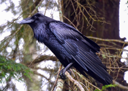

In [6]:
im = Image.open(dest)
im.to_thumb(128,128)

## Going to train a Neural Network to classify between ravens, crows, and blackbirds.
#### Get images for each category into different folders

In [7]:
bird_types = 'raven', 'crow', 'blackbird'
path = Path('birds')

In [8]:
download_images

<function fastai.vision.utils.download_images(dest, url_file=None, urls=None, max_pics=1000, n_workers=8, timeout=4, preserve_filename=False)>

In [9]:
if not path.exists():
    path.mkdir()
    for b in bird_types:
        dest = (path/b)
        dest.mkdir(exist_ok=True) # exist_ok=True => no error if dir already exists
        results = search_images_bing(key, f'{b}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [10]:
get_image_files

<function fastai.data.transforms.get_image_files(path, recurse=True, folders=None)>

In [11]:
allImages = get_image_files(path)

In [12]:
verify_images # find images that cannot be opened

<function fastai.vision.utils.verify_images(fns)>

In [13]:
failed = verify_images(allImages)

In [14]:
# We find no failed images. If we did we would unlink them
# failed.map(Path.unlink);

## The next step is to load these images along with their labels, split the dataset into train, validation for the NN